<a href="https://colab.research.google.com/github/mokunosuke/StyleGAN/blob/main/%E6%95%99%E6%9D%90_Anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==1.15
!pip install imageio==2.4.1
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Settings
import tensorflow
%rm -rf /content/sample_data
%cd /content/

!git clone https://github.com/NVlabs/stylegan.git
# !git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan
%mkdir -p results

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

import pickle
import scipy
import moviepy.editor


#@title load_Gs deffinition
_Gs_cache = dict()

def load_Gs(url):
    if url not in _Gs_cache:
        with open(url, 'rb') as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]

tflib.init_tf()
pretrained_model = "/content/drive/MyDrive/2019-02-26-stylegan-faces-network-02048-016041.pkl" #@param {type:"string"}
Gs = load_Gs(pretrained_model)

/content
fatal: destination path 'stylegan' already exists and is not an empty directory.
/content/stylegan



Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3923968/45929032 bytes (8.5%)7897088/45929032 bytes (17.2%)12050432/45929032 bytes (26.2%)16031744/45929032 bytes (34.9%)20201472/45929032 bytes (44.0%)23961600/45929032 bytes (52.2%)28024832/45929032 bytes (61.0%)31539200/45929032 bytes (68.7%)35684352/45929032 bytes (77.7%)38985728/45929032 bytes (84.9%)43114496/4

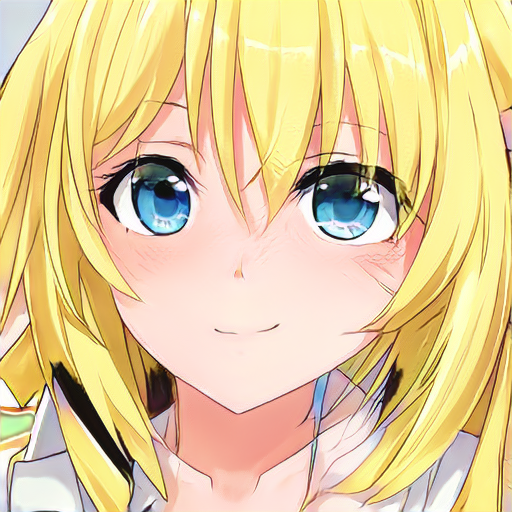

In [3]:
#@title Uncurated images
tflib.init_tf()

url = pretrained_model
Gs = load_Gs(url)

w = 512
h = 512

seeds = [234] #@param
psi  = 0.7 #@param {type:"number"}
canvas = PIL.Image.new('RGB', (w * len(seeds), h ), 'white')
for i, seed, in enumerate(seeds):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), ((i) * h, 0))
canvas


In [ ]:
#@title Style mixing

col_seeds = [ ] #@param
row_seeds = [ ]#@param
psi = 0.7 #@param
style_range = [  ] #@param

success = True
for n in style_range:
    if n > 15:
        print("style_rangeは15以下です")
        success = False


tflib.init_tf()

url = pretrained_model
Gs = load_Gs(url)

w,h = [512, 512]
canvas = PIL.Image.new('RGB', (w * (len(col_seeds) + 1), h * (len(row_seeds) + 1)), 'black')
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=fmt, truncation_psi=0.7, minibatch_size=8)

def genarate(seed):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    return PIL.Image.fromarray(images[0], 'RGB')

def mixing(col_seed, row_seed):
    rnd = np.random.RandomState(col_seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    src_dlatents = Gs.components.mapping.run(latents, None) 

    rnd = np.random.RandomState(row_seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    dst_dlatents  = Gs.components.mapping.run(latents, None) 
    
    col_dlatents = src_dlatents
    col_dlatents[0, style_range] = dst_dlatents[0, style_range]
    col_images = Gs.components.synthesis.run(col_dlatents, randomize_noise=False,  **synthesis_kwargs)
    # images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    return PIL.Image.fromarray(col_images[0], 'RGB')

# Source images

if success:
    for i, col_seed in enumerate(col_seeds):
        im = genarate(col_seed)
        canvas.paste(im, ((i+1) * w, 0))

    # Target images
    for i, row_seed in enumerate(row_seeds):
        im = genarate(row_seed)
        canvas.paste(im, (0,  (i+1) * h))

        for j, col_seed in enumerate(col_seeds):
            im = mixing(col_seed, row_seed)
            canvas.paste(im, ((j+1)*w,  (i+1) * h))
canvas

In [ ]:
#@title Truncation trick
tflib.init_tf()

url = pretrained_model
Gs = load_Gs(url)

w = 512
h = 512

seed = 0 #@param{type:"integer"}
psis = [-1.0, -0.5, 0, 0.5, 1.0] #@param 
canvas = PIL.Image.new('RGB', (w * len(psis), h ), 'white')
for i, psi in enumerate(psis):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), ((i) * h, 0))
canvas


In [ ]:
#@title Make a movie
grid_size = [  ] #@param 
image_shrink = 1  
image_zoom = 1 
duration_sec = 10.0  #@param {type:"number"}
smoothing_sec = 1.0 
mp4_fps = 10 #@param {type:"integer"}
mp4_codec = 'libx264' 
mp4_bitrate = '1M' #@param ["1M", "2M", "3M", "4M","5M"]
random_seed = 1 #@param {type:"integer"}
minibatch_size = 8 
mp4_file = 'results/random_grid_%s.mp4' % random_seed

tflib.init_tf()

url = pretrained_model
Gs = load_Gs(url)

num_frames = int(np.rint(duration_sec * mp4_fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents,
                [smoothing_sec * mp4_fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))

def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7,
                            randomize_noise=False, output_transform=fmt)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

display_height =  200#@param {type:'integer'}
movie_path_output = '/content/stylegan/' + mp4_file
display(moviepy.editor.ipython_display(movie_path_output, height=display_height, autoplay=1))